# Real Estate Market Selection Model

In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [2]:
df_train_test = pd.read_csv('df_train_test.csv')
df_validation = pd.read_csv('df_validation.csv')

#Breaking the test/train population into one group of FIPs the validation dataset into a different group of FIPs
#This will ensure that the validation dataset is both out of sample and out of time from the test/train dataset

fips_test_train = df_train_test.fips.sample(frac=0.7, replace=False, random_state=1)
df_train_test = df_train_test[df_train_test.fips.isin(fips_test_train.values)]
df_validation = df_validation[~df_validation.fips.isin(fips_test_train.values)]

In [3]:
df_train_test.columns

Index(['fips', 'zhvi_weighted_growth', '  Construction_growth',
       '  Finance, insurance, real estate, rental, and leasing_growth',
       '  Manufacturing_growth',
       '  Mining, quarrying, and oil and gas extraction_growth',
       '  Retail trade_growth', ' Private industries_growth',
       'All industry total_growth',
       'Government and government enterprises_growth', 'population_growth',
       'county', 'Census Population 2010', 'zhvi_weighted',
       ' Private industries', 'All industry total',
       'Government and government enterprises', 'population'],
      dtype='object')

In [4]:
target = 'zhvi_weighted_growth'

In [5]:
features = [
    '  Construction_growth',
       '  Finance, insurance, real estate, rental, and leasing_growth',
       '  Manufacturing_growth',
       '  Mining, quarrying, and oil and gas extraction_growth',
       '  Retail trade_growth',
       ' Private industries_growth',
       'All industry total_growth',
       'Government and government enterprises_growth',
       'population_growth',
       'zhvi_weighted', 
       ' Private industries',
       'All industry total', 
       'Government and government enterprises',
       'population'   
    
]

In [6]:
X, y = df_train_test[features],df_train_test[target]
X_val, y_val = df_validation[features],df_validation[target]

In [7]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [8]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=100,
                    num_boost_round=1000,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

#cv_results.head()
print((cv_results["test-rmse-mean"]).tail(1))

128    0.139331
Name: test-rmse-mean, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=123)


xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100)

xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=5,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [10]:
preds = xg_reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.094134


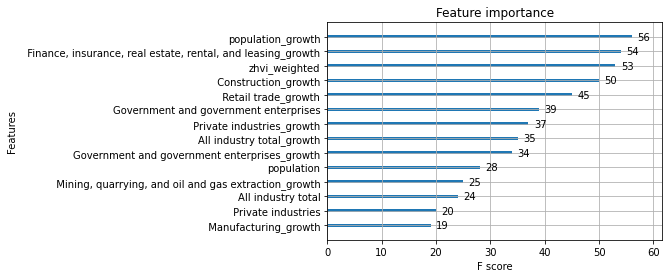

In [11]:
import matplotlib.pyplot as plt

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

Text(0.5, 1.0, 'Actual vs Predicted Appreciation')

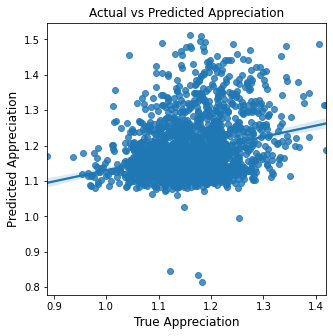

In [12]:
import seaborn as sns
p = sns.regplot(x = y_val, y= preds, )
p.set_xlabel("True Appreciation", fontsize = 12)
p.set_ylabel("Predicted Appreciation", fontsize = 12)
p.set_title("Actual vs Predicted Appreciation")

In [13]:


df_validation = pd.concat([y_val, pd.Series(preds)], axis=1)
df_validation.rename(columns={"zhvi_weighted_growth": "actual_appreciation", 0:"predicted_appreciation"}, inplace = True)



In [17]:
df_validation["actual_appreciation"]
df_validation['pred_deciles'] = pd.qcut(df_validation['predicted_appreciation'], q=40, precision=0)


Text(0.5, 1.0, 'Predicted vs Actual 3YR Appreciation for Validation Dataset')

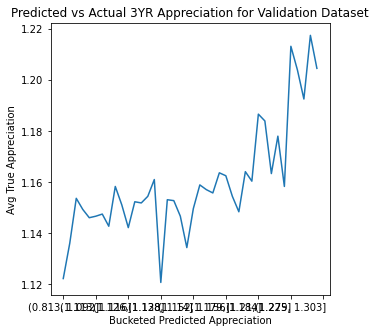

In [18]:
ax = df_validation.groupby('pred_deciles').actual_appreciation.mean().plot()
ax.set_xlabel("Bucketed Predicted Appreciation")
ax.set_ylabel("Avg True Appreciation")
ax.set_title("Predicted vs Actual 3YR Appreciation for Validation Dataset")

Text(0.5, 1.0, 'Std of Actual Appreciation vs Predicted Appreciation')

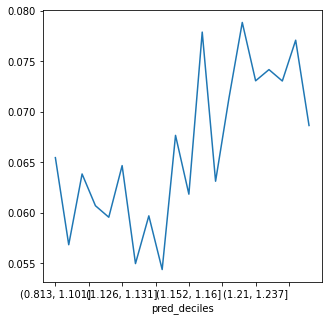

In [16]:
df_validation.groupby('pred_deciles').actual_appreciation.std().plot()
ax.set_xlabel("Bucketed Predicted Appreciation")
ax.set_ylabel("Standard Deviation in Actuals")
ax.set_title("Std of Actual Appreciation vs Predicted Appreciation")